
Neural networks are known to "trick" us by exploiting unobvious shortcuts to achieve good performance (e.g., when tasked with recognizing if a wolf or a dog is on the image, they could learn to recognize the features of terrain instead).  Convolutional Neural Networks (CNN) are extremely useful in image classification tasks. They recognize patterns in the data by encoding various features in the images such as edges, lines, circles.
We hope a neural network to depend solely on pixels it sees, but... position information might be useful as well.

Can a CNN recover information about the position of each pixel just from pixel values and padding? In this task, you will verify this hypothesis.

You have to implement a CNN model which will predict the position of each pixel (the x or y coordinate normalized to [0,1]) using convolutional layers.



The ideal model would output something like this: 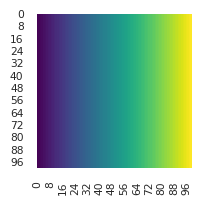

In [70]:
import torch.nn.functional as F
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


# Implement SimpleConvnet (5p)
This model consist of two parts:
- a parametrized number of blocks
- linear projection

Each block should have two layers: *convolution* and *relu*. The number of blocks is parametrized by the **n_convolutions** argument. All convolutions layers **in blocks** should have a kernel_size equal to 3 and padding equal to 1.

The input to the model has the shape: (batch_size, 1, spatial_dimension, spatial_dimension), so it starts with only 1 channel (filter). First 4 blocks should double the number of channels. Blocks from index 4 upward should keep the number of channels (filters) unchanged.

Linear projection should decrease the number of channels to 1. Therefore, the output of the model should match the input in shape.

In [71]:
class SimpleConvnet(nn.Module):
    def __init__(self, n_convolutions):
        super(SimpleConvnet, self).__init__()
        # TODO

        conv_blocks = [
           nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, padding=1),
           nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, padding=1),
           nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1),
           nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
        ]
        if n_convolutions > 4:
            conv_blocks += [nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)]*(n_convolutions-4)

        # print(len(conv_blocks))

        self.blocks = nn.ModuleList([
            nn.ReLU() if i%2 else conv_blocks[i//2] for i in range(2*n_convolutions)
        ] + [nn.Conv2d(in_channels=min(16, 2**n_convolutions), out_channels=1, kernel_size=1, padding=0)])

        # print(self.blocks)
        

        # END TODO


    def forward(self, x):
      # TODO
        for block in self.blocks:
            x = block(x)

        return x
      # END TODO


## Helper functions

In [72]:
def visualize(array):
  plt.figure(figsize=(2,2))
  sns.set(font_scale=0.7)
  sns.heatmap(array, cmap='viridis', cbar=False, annot=False)
  plt.show()

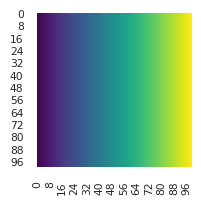

In [73]:
def generate_spectrum(spatial_dimension):
  row = torch.linspace(0, 1, spatial_dimension)
  return row.expand(spatial_dimension, -1)
spectrum = generate_spectrum(100)
visualize(spectrum.numpy())

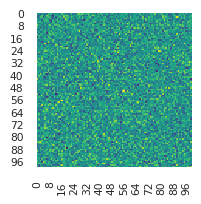

In [74]:
def generate_noise(batch_size, spatial_dimension):
  return torch.randn(batch_size, 1, spatial_dimension, spatial_dimension)
visualize(generate_noise(1,100)[0].squeeze().numpy())

## Training (1p)
Implement target preparation.

In [75]:

def train(epochs, steps, batch_size, model, optimizer, spatial_dimension, verbose=1):
    model.train()

    # TODO
    # Prepare target (it will be the same in every sample)
    target = torch.concatenate([generate_spectrum(spatial_dimension)]*batch_size).reshape(batch_size, 1, spatial_dimension, -1)
    # target = torch.tensor([generate_spectrum(spatial_dimension)]*batch_size).reshape(batch_size, 1, spatial_dimension, -1)
    # ENDTODO
    assert target.shape == torch.Size([batch_size, 1, spatial_dimension, spatial_dimension])

    for epoch in range(epochs):
        running_loss = 0
        for i in range(steps):
            noise = generate_noise(batch_size, spatial_dimension)
            predicted = model(noise)
            loss = F.mse_loss(predicted, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if verbose > 0:
          print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, epochs, running_loss / steps))
          with torch.no_grad():
            input = generate_noise(1, spatial_dimension)
            predicted_gradient = model(input)[0].numpy()
            visualize(predicted_gradient.squeeze(0))

In [76]:
# Check if training works
# do not exceed n_convolutions = 10 and spatial_dimension = 20
n_convolutions = 10
spatial_dimension = 20
epochs = 20
steps = 50

model = SimpleConvnet(n_convolutions)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train(epochs=epochs, steps=steps, batch_size=256, model=model, optimizer=optimizer, spatial_dimension=spatial_dimension, verbose=1)

## Experiments (5p)

Create two lists:
- *n_convolutions_params* with 4 different values (suggested [2, 4, 6, 8])
- *spatial_dimensions_params* with 4 different values (suggested [5,10,15,20])

For each pair (n_convolutions,spatial_dimensions) $\in$ (n_convolutions_params $\times$ spatial_dimensions_param), train a model with these parameters and visualize the prediction of the trained model on a sampled noise.

Represent these vizualizations on image grid of shape 4 $\times$ 4. Explain these results.

(Note: do not exceed n_convolutions = 10 and spatial_dimension = 20. It takes about 2min on CPU to train model with these parameters. )

(Note2: *visualize* function runs plt.show() so it can interfere with image grid. You can disable it by changing verbose argument in *train* to 0.)


In [ ]:
#TODO

n_convolutions_params = [2, 4, 6, 8]
spacial_dimensions_params = [5, 10, 15, 20]

indices = [0, 1, 2, 3]
predicted_gradients = []

for i, j in [[a, b] for a in indices for b in indices]:
    n_convolutions = n_convolutions_params[i]
    spacial_dimensions = spacial_dimensions_params[j]
    model = SimpleConvnet(n_convolutions)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 20
    steps = 50
    train(epochs=epochs, steps=steps, batch_size=256, model=model, optimizer=optimizer, spatial_dimension=spacial_dimensions, verbose=0)
    print(f"{i+j+1} out of 16 done")
    input = generate_noise(1, spatial_dimension)
    with(torch.no_grad()):
        predicted_gradients.append(model(input)[0].numpy())

# END TODO

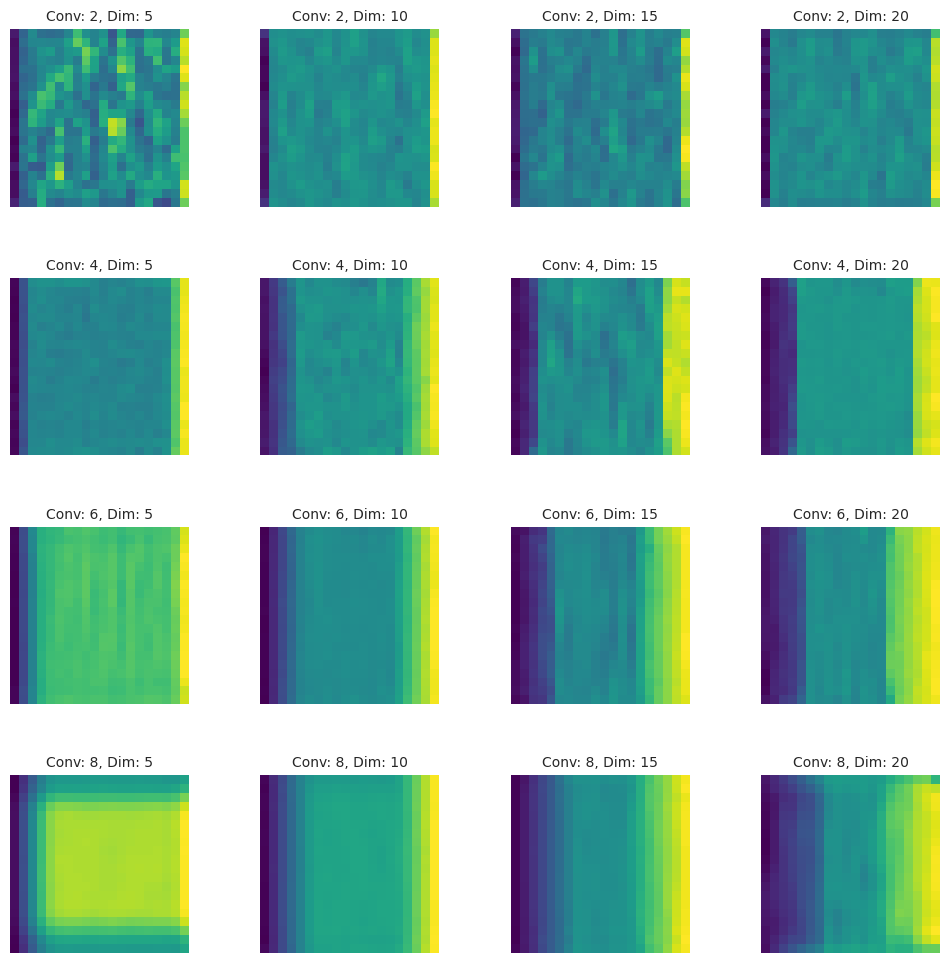

In [80]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for idx, ax in enumerate(axes.flat):
    i = idx // 4
    j = idx % 4
    
    n_conv = n_convolutions_params[i]
    s_dim = spacial_dimensions_params[j]
    
    data = predicted_gradients[idx].squeeze()
    
    sns.heatmap(data, ax=ax, cmap='viridis', cbar=False, annot=False)
    
    ax.set_title(f"Conv: {n_conv}, Dim: {s_dim}", fontsize=10)
    ax.axis('off')  # Hide axis ticks for cleaner look

plt.show()